# ***START***

# Install dependencies

In [26]:
!python --version

Python 3.11.13


In [27]:
import torch

print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

GPU Available: True
GPU Name: Tesla T4


# Import Libraries

In [28]:
import os
import cv2
import math
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [29]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torch.utils.checkpoint import checkpoint
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torchvision
from torchvision.models.detection.backbone_utils import BackboneWithFPN


In [30]:
IMG_DIR = "/kaggle/input/coco2017/val2017 (1)/val2017"
ANNOTATION_FILE = "/kaggle/input/coco2017/annotations_trainval2017/annotations/instances_val2017.json"

# Load Data

In [31]:
with open(ANNOTATION_FILE, 'r') as f:
    coco_data = json.load(f)

In [32]:
# Map image ID → filename
image_id_to_filename = {img["id"]: img["file_name"] for img in coco_data["images"]}

# Map image filename → list of (bbox, category_id)
image_records = {fname: [] for fname in image_id_to_filename.values()}

for ann in coco_data["annotations"]:
    fname = image_id_to_filename[ann["image_id"]]
    bbox = ann["bbox"]             # [x, y, w, h]
    category_id = ann["category_id"]

    # Append tuple (bbox, label) to the image record
    image_records[fname].append((bbox, category_id))

In [33]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import os

class CocoResizeDataset(Dataset):
    def __init__(self, img_dir, image_records, target_size, transforms=None):
        """
        img_dir: directory with images
        image_records: dict {filename: list of (bbox, label)}
        target_size: tuple (width, height)
        transforms: optional torchvision transforms
        """
        self.img_dir = img_dir
        self.records = image_records
        self.filenames = list(image_records.keys())
        self.target_size = target_size
        self.transforms = transforms or T.Compose([
            T.Resize(target_size),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.img_dir, fname)
        img = Image.open(img_path).convert("RGB")
        orig_w, orig_h = img.size

        # Apply transforms
        img_tensor = self.transforms(img)

        # Get annotations
        annots = self.records[fname]
        boxes = []
        labels = []
        for bbox, label in annots:
            x, y, w, h = bbox
            # Scale boxes according to target_size
            scale_x = self.target_size[0] / orig_w
            scale_y = self.target_size[1] / orig_h
            x_min = x * scale_x
            y_min = y * scale_y
            x_max = (x + w) * scale_x
            y_max = (y + h) * scale_y
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(label)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        return img_tensor, target


In [34]:
def get_bbox_size_category(box, img_w, img_h):
    """
    Categorize a bounding box based on its relative area in the image.

    box: [x_min, y_min, x_max, y_max] (absolute coordinates)
    img_w, img_h: dimensions of the current image
    Returns: 0=tiny, 1=small, 2=medium, 3=large
    """
    if isinstance(box, (list, tuple)):
        box = torch.tensor(box, dtype=torch.float32)
    x_min, y_min, x_max, y_max = box
    w = x_max - x_min
    h = y_max - y_min

    # Compute area relative to reference HR size (256x256)
    scaled_area = (w * h) * (256 * 256) / (img_w * img_h)

    if scaled_area <= 32**2:
        return 0  # tiny
    elif scaled_area <= 64**2:
        return 1  # small
    elif scaled_area <= 128**2:
        return 2  # medium
    else:
        return 3  # large

In [35]:
from collections import defaultdict
import random
from PIL import Image

# --------------------------
# 1. Compute max object size per image
# --------------------------
image_size_category = {}
for fname, records in image_records.items():
    if not records:
        continue

    img_path = os.path.join(IMG_DIR, fname)
    img = Image.open(img_path)
    img_w, img_h = img.size

    categories = []
    for bbox, _ in records:
        x, y, w, h = bbox
        bbox_xyxy = [x, y, x + w, y + h]
        categories.append(get_bbox_size_category(bbox_xyxy, img_w, img_h))
    image_size_category[fname] = max(categories)

# --------------------------
# 2. Group images by size
# --------------------------
size_groups = defaultdict(list)
for fname, cat in image_size_category.items():
    size_groups[cat].append(fname)

# --------------------------
# 3. Split each group into 70% train, 15% val, 15% test
# --------------------------
train_files = []
val_files = []
test_files = []

for cat, files in size_groups.items():
    random.shuffle(files)
    n = len(files)
    n_train = int(0.7 * n)
    n_val   = int(0.15 * n)
    n_test  = n - n_train - n_val  # remaining

    train_files += files[:n_train]
    val_files   += files[n_train:n_train+n_val]
    test_files  += files[n_train+n_val:]

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

# --------------------------
# 4. Filter records for each split
# --------------------------
train_records = {k: v for k, v in image_records.items() if k in train_files}
val_records   = {k: v for k, v in image_records.items() if k in val_files}
test_records  = {k: v for k, v in image_records.items() if k in test_files}

# --------------------------
# 5. Create LR datasets
# --------------------------
train_dataset_lr = CocoResizeDataset(img_dir=IMG_DIR, image_records=train_records, target_size=(64, 64))
val_dataset_lr   = CocoResizeDataset(img_dir=IMG_DIR, image_records=val_records, target_size=(64, 64))
test_dataset_lr  = CocoResizeDataset(img_dir=IMG_DIR, image_records=test_records, target_size=(64, 64))


Train: 3464, Val: 741, Test: 747


In [36]:
def count_objects_by_size(dataset):
    """
    Counts objects in each size category for a given dataset.
    All bounding boxes are scaled to HR reference (256x256) for consistent categorization.
    Returns: {0: tiny, 1: small, 2: medium, 3: large}
    """
    counts = {0: 0, 1: 0, 2: 0, 3: 0}

    for idx in range(len(dataset)):
        img_tensor, target = dataset[idx]

        boxes = target.get("boxes", [])
        if boxes is None or len(boxes) == 0:
            continue

        # Use dataset.target_size as the image size
        img_w, img_h = dataset.target_size

        for box in boxes:
            if isinstance(box, (list, tuple)):
                box = torch.tensor(box, dtype=torch.float32)
            cat = get_bbox_size_category(box, img_w, img_h)  # remove base_size argument
            counts[cat] += 1

    return counts


In [37]:
# Count objects by size in each dataset
train_lr_counts = count_objects_by_size(train_dataset_lr)
val_lr_counts   = count_objects_by_size(val_dataset_lr)
test_lr_counts  = count_objects_by_size(test_dataset_lr)

size_map = {0: "tiny", 1: "small", 2: "medium", 3: "large"}

print("=== Object counts by size ===")
print("Train LR:", {size_map[k]: v for k, v in train_lr_counts.items()})
print("Val LR:  ", {size_map[k]: v for k, v in val_lr_counts.items()})
print("Test LR: ", {size_map[k]: v for k, v in test_lr_counts.items()})


=== Object counts by size ===
Train LR: {'tiny': 14126, 'small': 5501, 'medium': 4027, 'large': 2453}
Val LR:   {'tiny': 2662, 'small': 1099, 'medium': 887, 'large': 537}
Test LR:  {'tiny': 2969, 'small': 1120, 'medium': 884, 'large': 516}


# Ploting Images

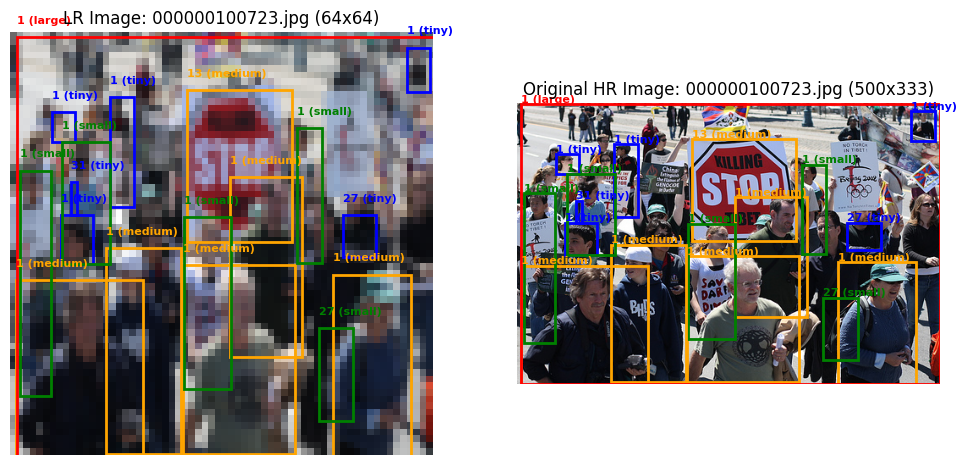

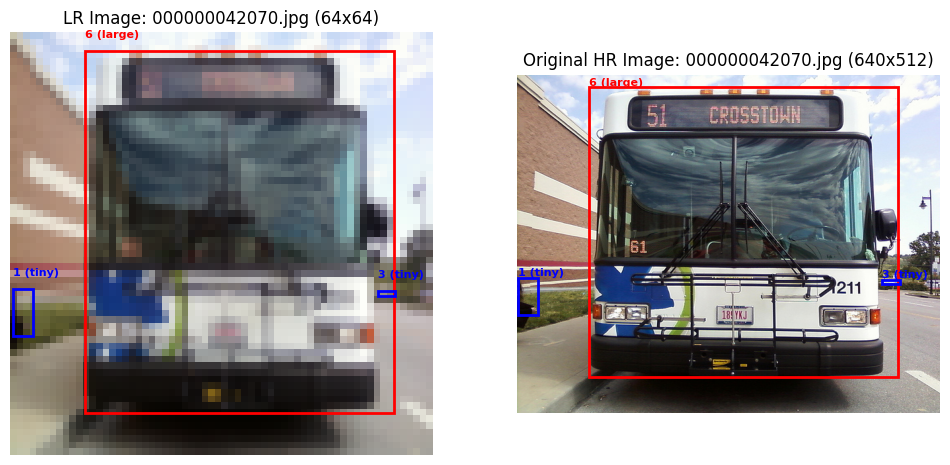

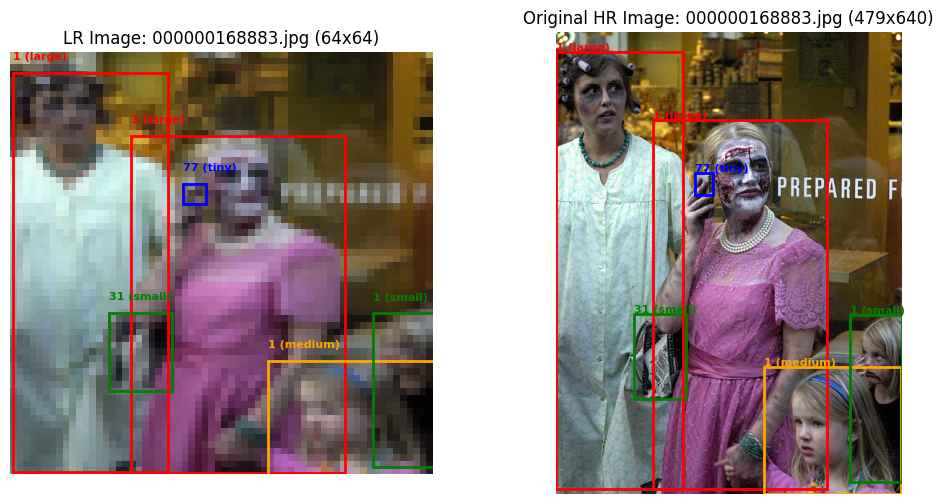

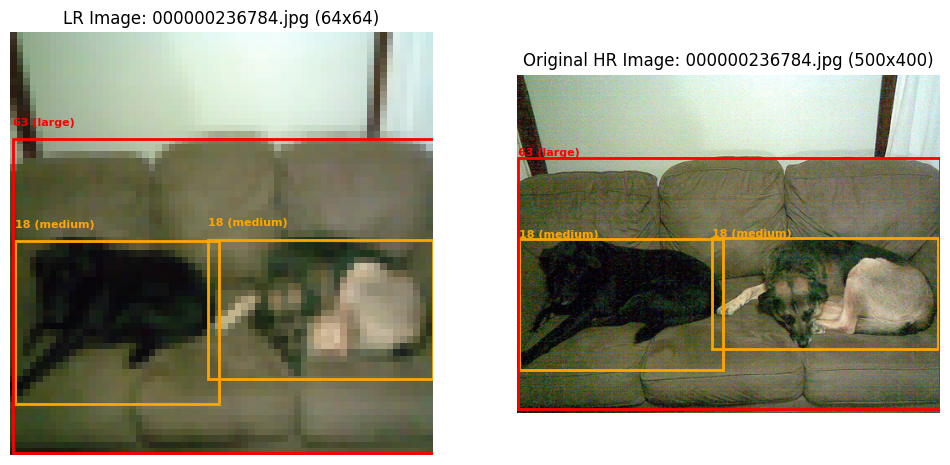

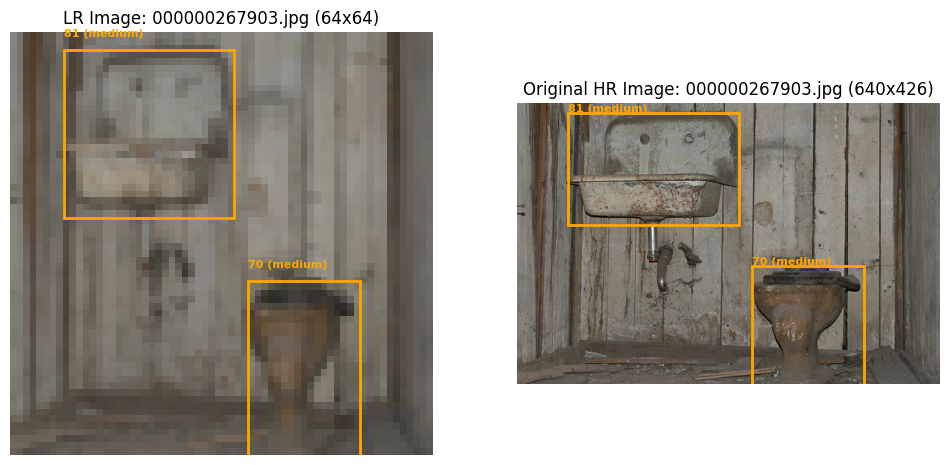

In [38]:
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as TF
import matplotlib.patches as patches
from PIL import Image
import os

# Color map for object sizes
size_colors = {0: "blue", 1: "green", 2: "orange", 3: "red"}
size_names  = {0: "tiny", 1: "small", 2: "medium", 3: "large"}

# Pick 5 random LR images from the train dataset
indices = random.sample(range(len(train_dataset_lr)), 5)

for idx in indices:
    img_tensor, target = train_dataset_lr[idx]
    fname = train_dataset_lr.filenames[idx]

    # Original image (for reference)
    orig_img = Image.open(os.path.join(IMG_DIR, fname)).convert("RGB")
    orig_w, orig_h = orig_img.size

    boxes, labels = target["boxes"], target["labels"]

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # LR image
    axes[0].imshow(TF.to_pil_image(img_tensor))
    axes[0].axis("off")
    axes[0].set_title(f"LR Image: {fname} (64x64)")

    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        cat = get_bbox_size_category(box, 64, 64)
        color = size_colors[cat]

        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor=color,
            facecolor="none"
        )
        axes[0].add_patch(rect)
        axes[0].text(x_min, y_min - 2, f"{labels[i].item()} ({size_names[cat]})",
                     color=color, fontsize=8, weight='bold')

    # Original HR image
    axes[1].imshow(orig_img)
    axes[1].axis("off")
    axes[1].set_title(f"Original HR Image: {fname} ({orig_w}x{orig_h})")

    for i, box in enumerate(boxes):
        # Scale box to original image size
        x_scale = orig_w / 64
        y_scale = orig_h / 64
        x_min, y_min, x_max, y_max = box
        x_min, y_min, x_max, y_max = x_min*x_scale, y_min*y_scale, x_max*x_scale, y_max*y_scale
        cat = get_bbox_size_category([x_min, y_min, x_max, y_max], orig_w, orig_h)
        color = size_colors[cat]

        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor=color,
            facecolor="none"
        )
        axes[1].add_patch(rect)
        axes[1].text(x_min, y_min - 2, f"{labels[i].item()} ({size_names[cat]})",
                     color=color, fontsize=8, weight='bold')

    plt.show()


# Wave Feature Layer

In [39]:
import torch
import torch.nn as nn
import math

# --------------------------
# CBAM Module (Safe & Optimized)
# --------------------------
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        reduction = min(reduction, channels)
        hidden = max(channels // reduction, 1)
        self.mlp = nn.Sequential(
            nn.Linear(channels, hidden, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels, bias=False)
        )
        self.spatial = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        B, C, H, W = x.shape
        # Channel attention
        avg_pool = x.mean(dim=(2,3))
        max_pool = x.amax(dim=(2,3))
        ca = torch.sigmoid(self.mlp(avg_pool) + self.mlp(max_pool)).view(B, C, 1, 1)
        x = x * ca
        # Spatial attention
        avg_out = x.mean(dim=1, keepdim=True)
        max_out = x.amax(dim=1, keepdim=True)
        sa = self.spatial(torch.cat([avg_out, max_out], dim=1))
        return x * sa

# --------------------------
# WaveFeatureLayer (Safe & Optimized)
# --------------------------
class WaveFeatureLayer(nn.Module):
    def __init__(self, in_channels, out_channels, num_waves_small=16, num_waves_large=16):
        super().__init__()
        # Ensure at least 1 output channel per branch
        self.small_branch = nn.Conv2d(in_channels, max(num_waves_small * 4,1), 1)
        self.cbam_small = CBAM(max(num_waves_small,1))
        self.large_branch = nn.Conv2d(in_channels, max(num_waves_large * 4,1), 1)
        self.cbam_large = CBAM(max(num_waves_large,1))
        # Fusion
        self.fusion_conv = nn.Conv2d(max(num_waves_small + num_waves_large,1), out_channels, 1)
        self.cbam_fusion = CBAM(out_channels)
        # Residual
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1)

    def forward_branch(self, x, branch_conv, cbam, coords_x, coords_y, wave_type='sin'):
        out = branch_conv(x)
        C = out.shape[1] // 4
        if C == 0:
            return torch.zeros_like(out)
        A, P, Fx, Fy = out[:, :C], out[:, C:2*C], out[:, 2*C:3*C], out[:, 3*C:]
        if wave_type == 'sin':
            wave = A * torch.sin(2*math.pi*(Fx*coords_x + Fy*coords_y) + P)
        else:
            wave = A * torch.cos(2*math.pi*(Fx*coords_x + Fy*coords_y) + P)
        # Normalize per batch
        max_val = wave.abs().amax(dim=(-2,-1), keepdim=True).clamp(min=1e-6)
        wave = wave / max_val
        return cbam(wave)

    def forward(self, x):
        B, C, H, W = x.shape
        device = x.device
        coords_x = torch.linspace(-1,1,W,device=device).view(1,1,1,W)
        coords_y = torch.linspace(-1,1,H,device=device).view(1,1,H,1)
        wave_small = self.forward_branch(x, self.small_branch, self.cbam_small, coords_x, coords_y, 'sin')
        wave_large = self.forward_branch(x, self.large_branch, self.cbam_large, coords_x, coords_y, 'cos')
        fused = self.fusion_conv(torch.cat([wave_small, wave_large], dim=1))
        fused = self.cbam_fusion(fused)
        residual = self.residual_conv(x)
        return fused + residual


# Model Build & Train


In [40]:
import torch, gc

# Clear PyTorch cache
torch.cuda.empty_cache()

# Run garbage collector
gc.collect()


30186

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --------------------------
# Config
# --------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 30
LR = 1e-5
BATCH_SIZE = 64
PATIENCE = 5
MODEL_SAVE_PATH = "wave_resnet18_detection.pth"
MAX_OBJECTS = 5  # max number of boxes per image

# --------------------------
# Detection Loss
# --------------------------
class DetectionHead(nn.Module):
    def __init__(self, in_channels, num_boxes=MAX_OBJECTS):
        super(DetectionHead, self).__init__()
        self.num_boxes = num_boxes
        self.box_regressor = nn.Conv2d(in_channels, num_boxes * 4, kernel_size=1)
        self.score_regressor = nn.Conv2d(in_channels, num_boxes, kernel_size=1)

    def forward(self, x):
        # x: [B, C, 1, 1]
        box_pred = self.box_regressor(x).view(x.size(0), self.num_boxes, 4)
        score_pred = self.score_regressor(x).view(x.size(0), self.num_boxes, 1)
        return box_pred, score_pred

# --------------------------
# Detection Head
# --------------------------
def detection_loss(pred_boxes, pred_scores, gt_boxes_list, max_objects=MAX_OBJECTS):
    total_loss = 0.0
    batch_size = len(gt_boxes_list)

    for i, target in enumerate(gt_boxes_list):
        gt_boxes = target["boxes"].to(pred_boxes.device)  # <-- take only boxes tensor
        if len(gt_boxes) == 0:
            continue

        n_obj = min(len(gt_boxes), max_objects)
        gt = gt_boxes[:n_obj]
        pred = pred_boxes[i, :n_obj]
        pred_score = pred_scores[i, :n_obj]

        # Box regression loss
        box_loss = F.smooth_l1_loss(pred, gt)

        # Classification loss (all GT boxes = object present)
        gt_label = torch.ones_like(pred_score)
        cls_loss = F.binary_cross_entropy_with_logits(pred_score, gt_label)

        total_loss += box_loss + cls_loss

    total_loss /= batch_size
    return total_loss


# --------------------------
# Models
# --------------------------
backbone = torch.hub.load('pytorch/vision:v0.15.2', 'resnet18', pretrained=True)
backbone.fc = nn.Identity()
backbone = backbone.to(DEVICE)

wave_model = WaveFeatureLayer(in_channels=512, out_channels=256).to(DEVICE)
det_head = DetectionHead(in_channels=256, num_boxes=MAX_OBJECTS).to(DEVICE)

optimizer = torch.optim.AdamW(
    list(backbone.parameters()) + list(wave_model.parameters()) + list(det_head.parameters()),
    lr=LR
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# --------------------------
# Data Loaders
# --------------------------
train_loader = DataLoader(train_dataset_lr, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_dataset_lr, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

best_val_loss = float('inf')
early_stop_counter = 0

# --------------------------
# Training Loop
# --------------------------
for epoch in range(NUM_EPOCHS):
    backbone.train()
    wave_model.train()
    det_head.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)

    for imgs, targets in loop:
        imgs = torch.stack([img.to(DEVICE) for img in imgs])
        feats = backbone(imgs).unsqueeze(-1).unsqueeze(-1)
        feats_wave = wave_model(feats)
        pred_boxes, pred_scores = det_head(feats_wave)

        loss = detection_loss(pred_boxes, pred_scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix(loss=train_loss/(loop.n+1))

    avg_train_loss = train_loss / len(train_loader)

    # ----- Validation -----
    backbone.eval()
    wave_model.eval()
    det_head.eval()
    val_loss = 0.0

    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = torch.stack([img.to(DEVICE) for img in imgs])
            feats = backbone(imgs).unsqueeze(-1).unsqueeze(-1)
            feats_wave = wave_model(feats)
            pred_boxes, pred_scores = det_head(feats_wave)

            loss = detection_loss(pred_boxes, pred_scores, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # ----- Early Stopping -----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save({
            'backbone': backbone.state_dict(),
            'wave_model': wave_model.state_dict(),
            'det_head': det_head.state_dict(),
            'optimizer': optimizer.state_dict()
        }, MODEL_SAVE_PATH)
        print(f"Model saved at epoch {epoch+1}")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.15.2


Epoch 1 | Train Loss: 33.0397 | Val Loss: 32.9221
Model saved at epoch 1


Epoch 2 | Train Loss: 32.3694 | Val Loss: 32.2498
Model saved at epoch 2


Epoch 3 | Train Loss: 31.7616 | Val Loss: 31.5842
Model saved at epoch 3


Epoch 4 | Train Loss: 31.0384 | Val Loss: 30.8267
Model saved at epoch 4


Epoch 5 | Train Loss: 30.3690 | Val Loss: 30.1009
Model saved at epoch 5


Epoch 6 | Train Loss: 29.5299 | Val Loss: 29.2479
Model saved at epoch 6


Epoch 7 | Train Loss: 28.4974 | Val Loss: 28.2498
Model saved at epoch 7


Epoch 8 | Train Loss: 27.5226 | Val Loss: 27.2416
Model saved at epoch 8


Epoch 9 | Train Loss: 26.4112 | Val Loss: 26.0572
Model saved at epoch 9


Epoch 10 | Train Loss: 25.3442 | Val Loss: 24.8381
Model saved at epoch 10


Epoch 11 | Train Loss: 24.0731 | Val Loss: 23.6871
Model saved at epoch 11


Epoch 12 | Train Loss: 22.9661 | Val Loss: 22.5914
Model saved at epoch 12


Epoch 13 | Train Loss: 21.6690 | Val Loss: 21.4607
Model saved at epoch 13


Epoch 14 | Train Loss: 20.4547 | Val Loss: 20.3109
Model saved at epoch 14


Epoch 15 | Train Loss: 19.3535 | Val Loss: 19.1169
Model saved at epoch 15


Epoch 16 | Train Loss: 18.2573 | Val Loss: 18.0785
Model saved at epoch 16


Epoch 17 | Train Loss: 17.2815 | Val Loss: 17.0840
Model saved at epoch 17


Epoch 18 | Train Loss: 16.3267 | Val Loss: 16.2926
Model saved at epoch 18


Epoch 19 | Train Loss: 15.5250 | Val Loss: 15.8185
Model saved at epoch 19


Epoch 20 | Train Loss: 14.8116 | Val Loss: 15.1142
Model saved at epoch 20


Epoch 21 | Train Loss: 14.2560 | Val Loss: 14.6870
Model saved at epoch 21


Epoch 22 | Train Loss: 13.6891 | Val Loss: 14.1568
Model saved at epoch 22


Epoch 23 | Train Loss: 13.2910 | Val Loss: 13.8835
Model saved at epoch 23


Epoch 24 | Train Loss: 12.8609 | Val Loss: 13.6520
Model saved at epoch 24


Epoch 25 | Train Loss: 12.5729 | Val Loss: 13.3959
Model saved at epoch 25


Epoch 26 | Train Loss: 12.3663 | Val Loss: 13.2354
Model saved at epoch 26


Epoch 27 | Train Loss: 12.1693 | Val Loss: 13.1109
Model saved at epoch 27


Epoch 28 | Train Loss: 11.9474 | Val Loss: 13.0577
Model saved at epoch 28


Epoch 29 | Train Loss: 11.8298 | Val Loss: 13.0202
Model saved at epoch 29


Epoch 30 | Train Loss: 11.7413 | Val Loss: 12.9212
Model saved at epoch 30


# Analysis

Evaluating: 100%|██████████| 47/47 [00:13<00:00,  3.45it/s]


Average Precision per Object Size:
  medium: 0.0486
  tiny: 0.0003
  small: 0.0125
  large: 0.0388


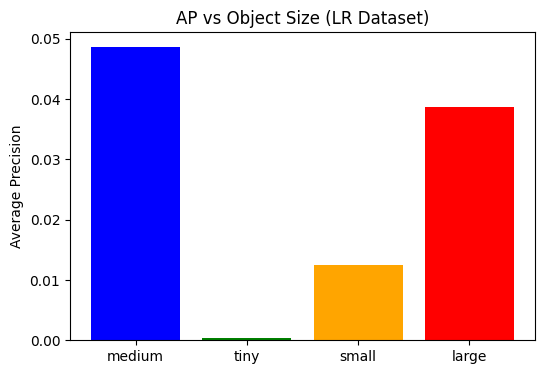

Chart saved as ap_vs_object_size.png


In [44]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

# --------------------------
# Config
# --------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16

# Load model
checkpoint = torch.load("wave_resnet18_detection.pth", map_location=DEVICE)
backbone.load_state_dict(checkpoint['backbone'])
wave_model.load_state_dict(checkpoint['wave_model'])
det_head.load_state_dict(checkpoint['det_head'])
backbone.eval()
wave_model.eval()
det_head.eval()

# --------------------------
# DataLoader
# --------------------------
test_loader = DataLoader(test_dataset_lr, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# --------------------------
# Evaluation
# --------------------------
size_map = {0: "tiny", 1: "small", 2: "medium", 3: "large"}
size_precisions = defaultdict(list)

with torch.no_grad():
    for imgs, targets in tqdm(test_loader, desc="Evaluating"):
        imgs = torch.stack([img.to(DEVICE) for img in imgs])
        feats = backbone(imgs)
        feats = feats.unsqueeze(-1).unsqueeze(-1)
        feats_wave = wave_model(feats)
        pred_boxes, pred_scores = det_head(feats_wave)

        for i, target in enumerate(targets):
            gt_boxes = target["boxes"].to(DEVICE)
            n_obj = len(gt_boxes)
            if n_obj == 0:
                continue

            pred = pred_boxes[i]
            scores = torch.sigmoid(pred_scores[i].squeeze())

            for j in range(n_obj):
                gt_box = gt_boxes[j]
                size_cat = get_bbox_size_category(gt_box, *test_dataset_lr.target_size)

                # Compute IoU for predicted boxes
                ious = []
                for k in range(pred.shape[0]):
                    px1, py1, px2, py2 = pred[k]
                    gx1, gy1, gx2, gy2 = gt_box
                    xi1 = max(px1, gx1)
                    yi1 = max(py1, gy1)
                    xi2 = min(px2, gx2)
                    yi2 = min(py2, gy2)
                    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
                    gt_area = (gx2 - gx1) * (gy2 - gy1)
                    pred_area = (px2 - px1) * (py2 - py1)
                    union_area = gt_area + pred_area - inter_area
                    iou = inter_area / (union_area + 1e-6)
                    ious.append(iou)

                max_iou = max(ious)
                # Consider as TP if IoU >= 0.5
                precision = 1.0 if max_iou >= 0.5 else 0.0
                size_precisions[size_cat].append(precision)

# --------------------------
# Compute Average Precision per Size
# --------------------------
avg_precision = {}
for k in size_precisions:
    if len(size_precisions[k]) > 0:
        avg_precision[k] = sum(size_precisions[k]) / len(size_precisions[k])
    else:
        avg_precision[k] = 0.0

# Print
print("Average Precision per Object Size:")
for k, v in avg_precision.items():
    print(f"  {size_map[k]}: {v:.4f}")

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(6,4))
plt.bar([size_map[k] for k in avg_precision.keys()], [v for v in avg_precision.values()], color=['blue','green','orange','red'])
plt.ylabel("Average Precision")
plt.title("AP vs Object Size (LR Dataset)")
# Save the figure
plt.savefig("ap_vs_object_size.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("Chart saved as ap_vs_object_size.png")

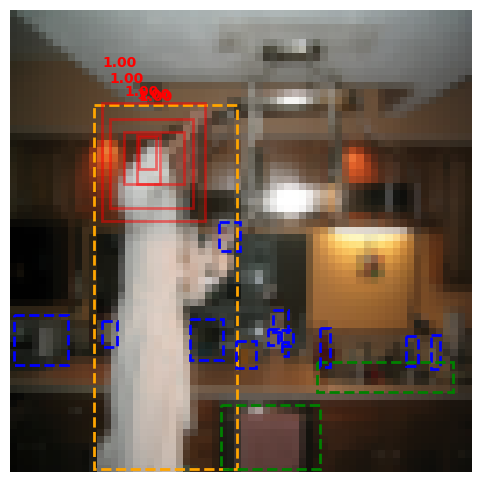

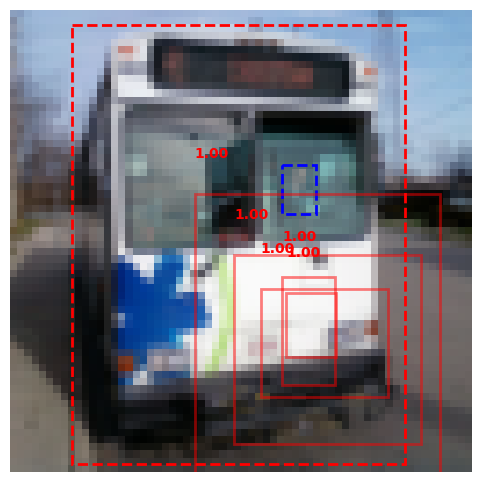

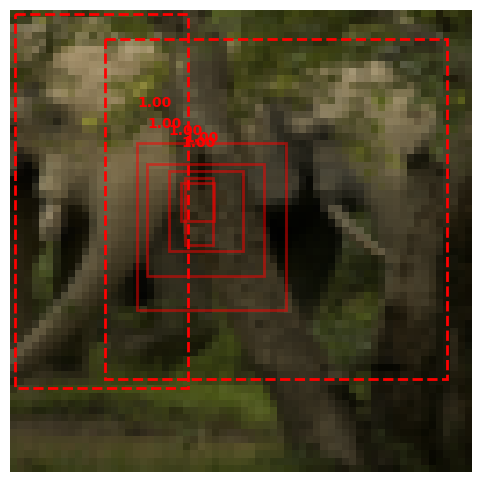

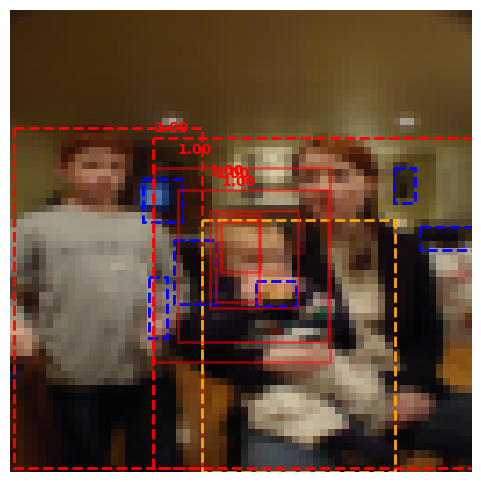

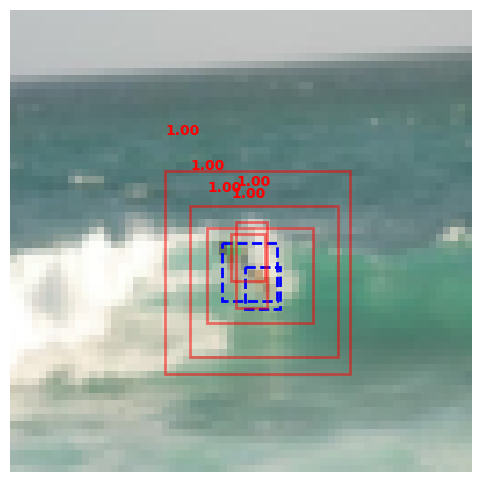

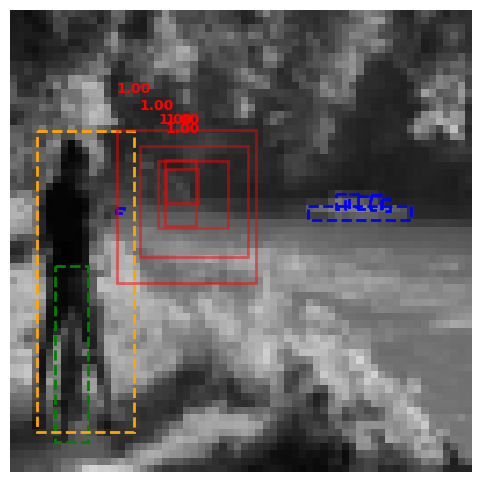

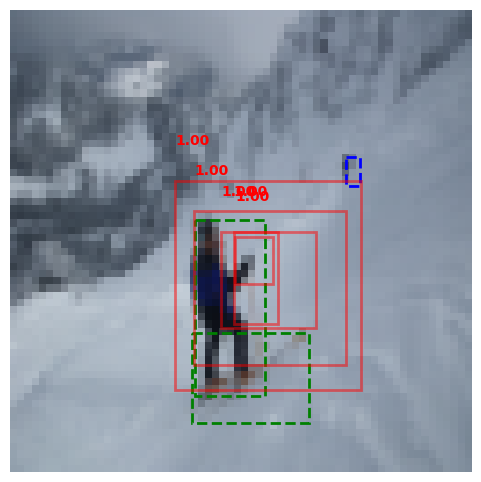

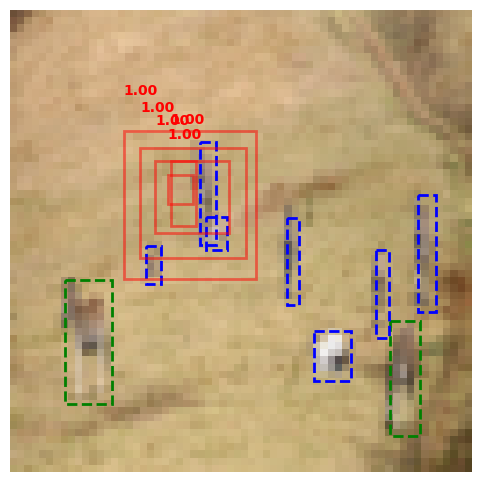

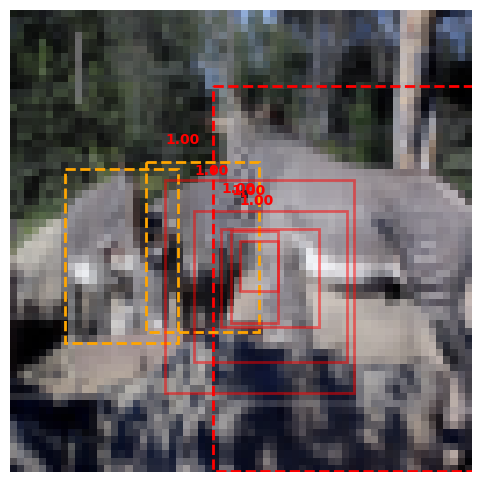

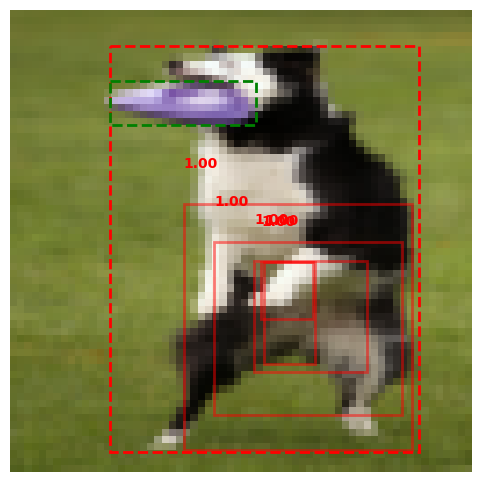

In [43]:
import random
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# --------------------------
# Pick 10 random indices
# --------------------------
num_images = 10
all_indices = list(range(len(test_dataset_lr)))
random_indices = random.sample(all_indices, num_images)

# --------------------------
# Evaluation & Plotting (only 10 images)
# --------------------------
with torch.no_grad():
    for idx in random_indices:
        img, target = test_dataset_lr[idx]
        img = img.to(DEVICE).unsqueeze(0)
        feats = backbone(img)
        feats = feats.unsqueeze(-1).unsqueeze(-1)
        feats_wave = wave_model(feats)
        pred_boxes, pred_scores = det_head(feats_wave)

        gt_boxes = target["boxes"].to(DEVICE)
        n_obj = len(gt_boxes)
        if n_obj == 0:
            continue

        pred = pred_boxes[0]
        scores = torch.sigmoid(pred_scores[0].squeeze())

        # Plot image
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(img[0].cpu().permute(1,2,0).numpy())
        ax.axis("off")

        # Draw GT boxes
        for j in range(n_obj):
            gx_min, gy_min, gx_max, gy_max = gt_boxes[j].cpu().numpy()
            size_cat = get_bbox_size_category(gt_boxes[j], *test_dataset_lr.target_size)
            rect = patches.Rectangle(
                (gx_min, gy_min), gx_max-gx_min, gy_max-gy_min,
                linewidth=2, edgecolor=size_colors[size_cat], facecolor='none', linestyle='--'
            )
            ax.add_patch(rect)

        # Draw predicted boxes with scores
        for j in range(pred.shape[0]):
            px_min, py_min, px_max, py_max = pred[j].cpu().numpy()
            score = scores[j].item()
            rect = patches.Rectangle(
                (px_min, py_min), px_max-px_min, py_max-py_min,
                linewidth=2, edgecolor='red', facecolor='none', alpha=0.5
            )
            ax.add_patch(rect)
            ax.text(px_min, py_min - 5, f"{score:.2f}", color='red', fontsize=10, weight='bold')

        plt.show()


# ***END***